In [3]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import joblib


In [4]:

# Load dataset
df = pd.read_csv(r'D:\HREmployeeAttritionandanalysis\Modified_HR_Employee_Attrition_Data1.csv', encoding='latin1')
df1 = df.copy()



In [5]:
# Clean column names
df1.columns = df1.columns.str.replace("'", "")

In [6]:
# First separate features and target, excluding ExitStatement
X = df1.drop(['Attrition', 'ExitStatement'], axis=1)
y = df1['Attrition']


In [7]:

# Now identify numerical and categorical columns from X
numerical_columns = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("\nNumerical columns:", numerical_columns)
print("\nCategorical columns:", categorical_columns)




Numerical columns: ['DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

Categorical columns: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime', 'StockOptionLevel']


In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class DynamicOutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile=0.01, upper_quantile=0.99):
        
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile

    def fit(self, X, y=None):
       
        self.quantiles_ = {
            col: (X[col].quantile(self.lower_quantile), X[col].quantile(self.upper_quantile))
            for col in X.columns if pd.api.types.is_numeric_dtype(X[col])
        }
        return self

    def transform(self, X):
        
        X = X.copy()
        for col, (lower, upper) in self.quantiles_.items():
            X[col] = X[col].clip(lower=lower, upper=upper)
        return X

In [9]:
# Create the preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('outlier_handler', DynamicOutlierHandler(lower_quantile=0.01, upper_quantile=0.99)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Changed from sparse to sparse_output
])

In [10]:
# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)



In [11]:
# Create the full pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])



In [12]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)



In [13]:
# Fit the pipeline
print("Starting pipeline fit...")
model_pipeline.fit(X_train, y_train)
print("Pipeline fitted successfully!")



Starting pipeline fit...


Pipeline fitted successfully!


In [14]:
# Save the pipeline
joblib.dump(model_pipeline, 'hr_model.pkl')
print("Pipeline saved as 'hr_model.pkl'")



Pipeline saved as 'hr_model.pkl'


In [15]:
# Print evaluation metrics
from sklearn.metrics import accuracy_score, classification_report
y_pred = model_pipeline.predict(X_test)
print("\nModel Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Performance:
Accuracy: 0.8886

Classification Report:
              precision    recall  f1-score   support

          No       0.91      0.96      0.94       320
         Yes       0.61      0.40      0.48        48

    accuracy                           0.89       368
   macro avg       0.76      0.68      0.71       368
weighted avg       0.87      0.89      0.88       368



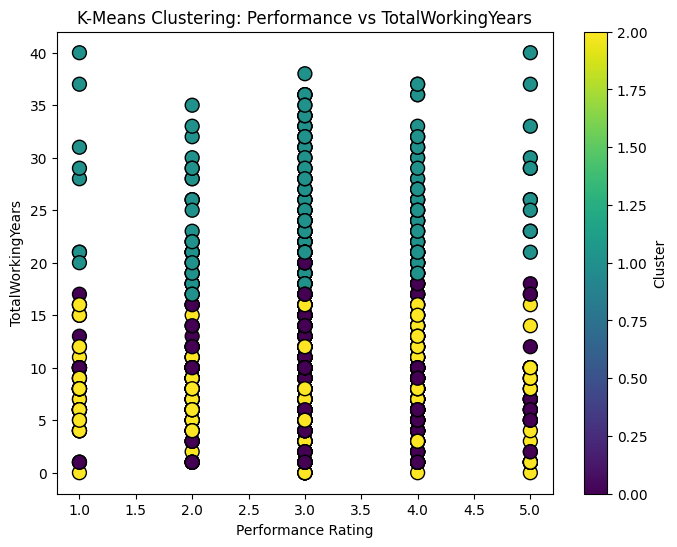

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Define the K-Means clustering pipeline
kmeans_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values by imputing the mean
    ('scaler', StandardScaler()),  # Scale the features for better K-Means performance
    ('kmeans', KMeans(n_clusters=3, random_state=42))  # Apply K-Means clustering with 3 clusters
])


# Select the relevant columns
columns_to_cluster = ['PerformanceRating', 'JobSatisfaction', 'TotalWorkingYears']
df_selected = df1[columns_to_cluster]

# Apply the K-Means pipeline
kmeans_pipeline.fit(df_selected)

# Retrieve cluster labels
cluster_labels = kmeans_pipeline['kmeans'].labels_

# Add the cluster labels to the original DataFrame
df1['Cluster'] = cluster_labels

plt.figure(figsize=(8, 6))
plt.scatter(
    df1['PerformanceRating'], df1['TotalWorkingYears'], 
    c=df1['Cluster'], cmap='viridis', s=100, edgecolor='k'
)

# Add plot labels and title
plt.xlabel('Performance Rating')
plt.ylabel('TotalWorkingYears')
plt.title('K-Means Clustering: Performance vs TotalWorkingYears')
plt.colorbar(label='Cluster')
plt.show()



In [17]:
import pandas as pd
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import re
import nltk
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import re
from nltk.stem import WordNetLemmatizer
import seaborn as sns

In [18]:
nltk.download('punkt')  # For word tokenization
nltk.download('stopwords')  # For stopwords
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abhil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

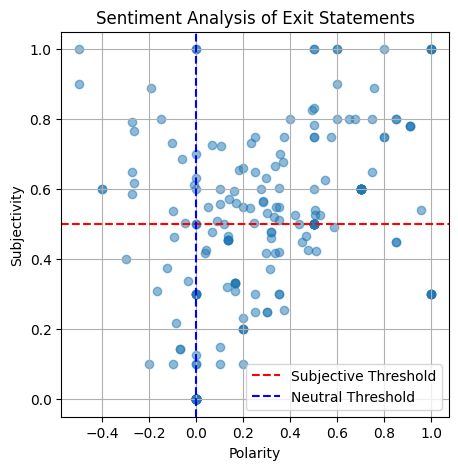

In [19]:
import pandas as pd
from textblob import TextBlob
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Custom Transformer for Sentiment Analysis
class SentimentAnalyzer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['Polarity'] = X['ExitStatement'].apply(
            lambda text: TextBlob(text).polarity if pd.notnull(text) else None
        )
        X['Subjectivity'] = X['ExitStatement'].apply(
            lambda text: TextBlob(text).subjectivity if pd.notnull(text) else None
        )
        return X

df_sentiment = df1.dropna(subset=['ExitStatement'])

# Sentiment Analysis Pipeline
sentiment_pipeline = Pipeline(steps=[
    ('sentiment_analysis', SentimentAnalyzer())
])

# Apply the pipeline
df_processed = sentiment_pipeline.fit_transform(df_sentiment)

plt.figure(figsize=(5, 5))
plt.scatter(df_processed['Polarity'], df_processed['Subjectivity'], alpha=0.5)
plt.title('Sentiment Analysis of Exit Statements')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.grid(True)
plt.axhline(0.5, color='red', linestyle='--', label='Subjective Threshold')
plt.axvline(0, color='blue', linestyle='--', label='Neutral Threshold')
plt.legend()
plt.show()





In [20]:
joblib.dump(sentiment_pipeline, 'sentiment_model.pkl')
print("Pipeline saved as 'sentiment_pipeline.pkl'")

Pipeline saved as 'sentiment_pipeline.pkl'
